# Setup

In [ ]:
# === Standard Library ===
import os
import sys
# === Scientific Computing ===
import numpy as np
from sklearn.mixture import GaussianMixture

# === Torch & TorchVision ===
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# === Plotting ===
import matplotlib.pyplot as plt
%matplotlib inline

# === Progress Bar ===
from tqdm import tqdm

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

# === Local Project Modules ===
sys.path.append("..")  # Temporary path extension for imports

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.plot_pcx_explanations import plot_pcx_explanations
from src.minio_client import MinIOClient

# === LCRP Utilities ===
from LCRP.models import get_model
from LCRP.utils.crp_configs import ATTRIBUTORS, CANONIZERS, VISUALIZATIONS, COMPOSITES


In [3]:
# Define transformation (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load dataset
root_dir = "../datasets/data/General_Flood_v3/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)

model_name = "unet"
device = "cuda" if torch.cuda.is_available() else "cpu"
output_dir_crp = "output/crp/unet_flood_old/"

# Loading unet with path to checkpoint
model = get_model(model_name=model_name, classes=2, ckpt_path="../models/checkpoints/unet_flood_modified.pt")

Loaded checkpoint ../models/checkpoints/unet_flood_modified.pt


# Running and saving attributions of our dataset per layer

You don't need to run it if PCX results are already saved!!! 

In [ ]:
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
# cc = ChannelConcept()

# layer_names = get_layer_names(model, [torch.nn.Conv2d])
# # Setting up CRP 
# attribution = ATTRIBUTORS["unet"](model)
# composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
# condition = [{"y": 1}]    
# fv = VISUALIZATIONS[model_name](attribution,
#                                     dataset,
#                                     layer_names,
#                                     preprocess_fn=lambda x: x,
#                                     path=output_dir_crp,
#                                     max_target="max")


# # Runs faster on MPS
# device = "mps"
# model.to(device)

# for layer_name in layer_names:

#     activations = []
#     attributions = []
#     if layer_name not in os.listdir("output/pcx/unet_flood/"):
#         print(layer_name)
#         for i, (x, y) in enumerate(tqdm(dataset)):
#             x = x.to(device).requires_grad_()
#             condition = [{"y": 1}]
#             attr = attribution(x.unsqueeze(0), condition, composite, record_layer=layer_names)

#             activations.append(attr.activations[layer_name].amax((-2, -1)))
#             attributions.append(cc.attribute(attr.relevances[layer_name], abs_norm=True))

#         attributions = torch.cat(attributions)
#         activations = torch.cat(activations)

#         folder = f"output/pcx/unet_flood/{layer_name}/"
#         os.makedirs(folder, exist_ok=True)
#         np.save(folder + "attributions", attributions.cpu().numpy())
#         np.save(folder + "activations", activations.cpu().numpy())

# Fitting GMM - Clustering Attributions

Here for each layer we can fit an GMM and check how many components we want for cluster

In [58]:
# Loading
layer_name = "decoder.center.0.0"
folder = f"output/pcx/unet_flood/{layer_name}/"
attributions = torch.from_numpy(np.load(folder + "attributions.npy"))
activations = torch.from_numpy(np.load(folder + "activations.npy"))
indices = np.arange(len(dataset))

In [59]:
from umap import UMAP

embedding_attr = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_attr = embedding_attr.fit_transform(attributions.detach().cpu().numpy())
x_attr, y_attr = X_attr[:, 0], X_attr[:, 1]

embedding_act = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_act = embedding_act.fit_transform(activations.detach().cpu().numpy())
x_act, y_act = X_act[:, 0], X_act[:, 1]

/Users/golimblevskaia/Documents/code/FHHI-XAI/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/golimblevskaia/Documents/code/FHHI-XAI/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/var/folders/pz/9xtgdh150n7dbrr_vfbbr4tr0000gq/T/ipykernel_25091/767869593.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


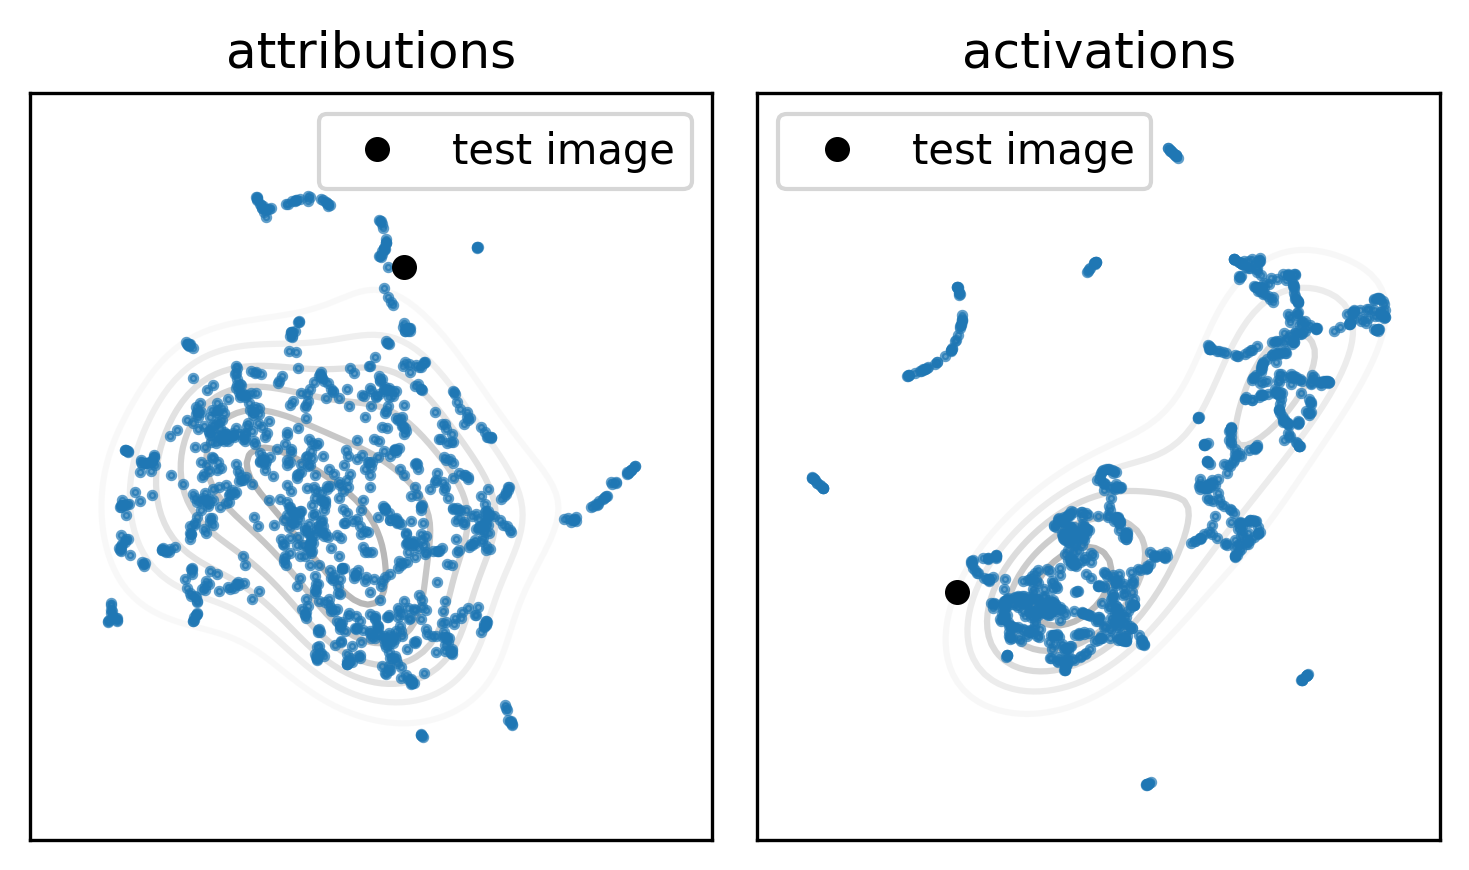

In [60]:
from scipy import stats
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(5, 3), facecolor='white')
for i, X in enumerate([X_attr, X_act]):
    x, y = X[:, 0], X[:, 1]
    xmin = x.min() - 2
    xmax = x.max() + 2
    ymin = y.min() - 2
    ymax = y.max() + 2
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values, 0.5)
    Z = np.reshape(kernel(positions).T, X.shape).T
    axes[i].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
    axes[i].scatter(x, y, s=3, alpha=0.7, zorder=1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(["attributions", "activations"][i])
    axes[i].plot([1], y[1], 'ko', markersize=5, label="test image")
    axes[i].legend()
plt.tight_layout()
fig.show()

/Users/golimblevskaia/Documents/code/FHHI-XAI/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/golimblevskaia/Documents/code/FHHI-XAI/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


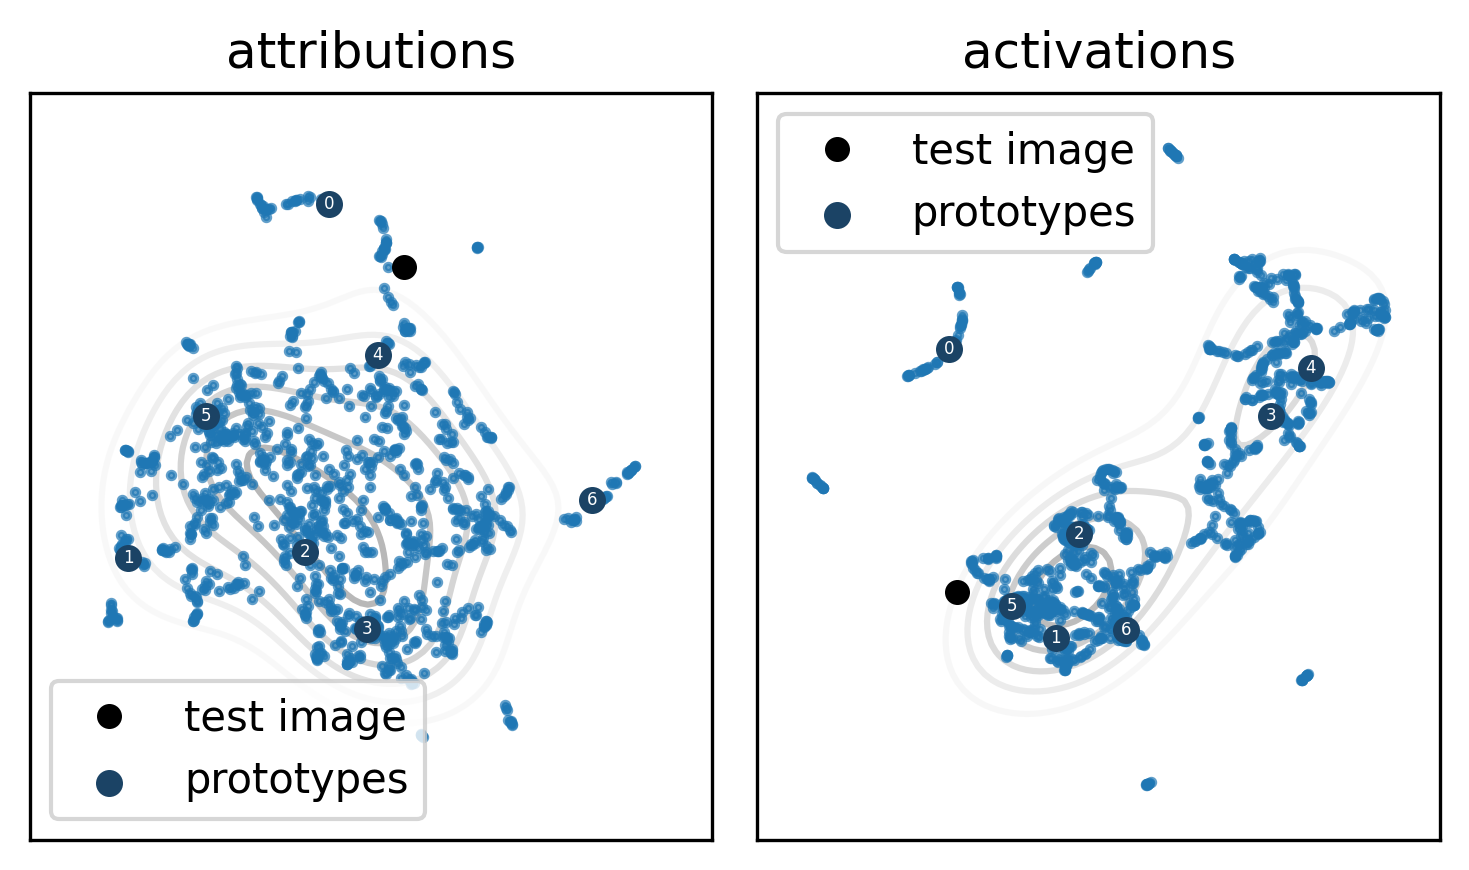

In [ ]:
N_PROTOTYPES = 7
prototypes = []
gmms = []
for i, (X, emb) in enumerate([(attributions, embedding_attr), (activations, embedding_act)]):
    gmms.append(GaussianMixture(n_components=N_PROTOTYPES, random_state=0).fit(X.detach().cpu().numpy()))
    prototypes.append(gmms[-1].means_)
    mean = emb.transform(gmms[-1].means_)
    axes[i].scatter(mean[:, 0], mean[:, 1], s=30, c="#1B4365", zorder=2, label="prototypes")
    for k, prot in enumerate(mean):
        axes[i].text(prot[0], prot[1], k, fontsize=4, color="white", ha="center", va="center")
    axes[i].legend()

display(fig)

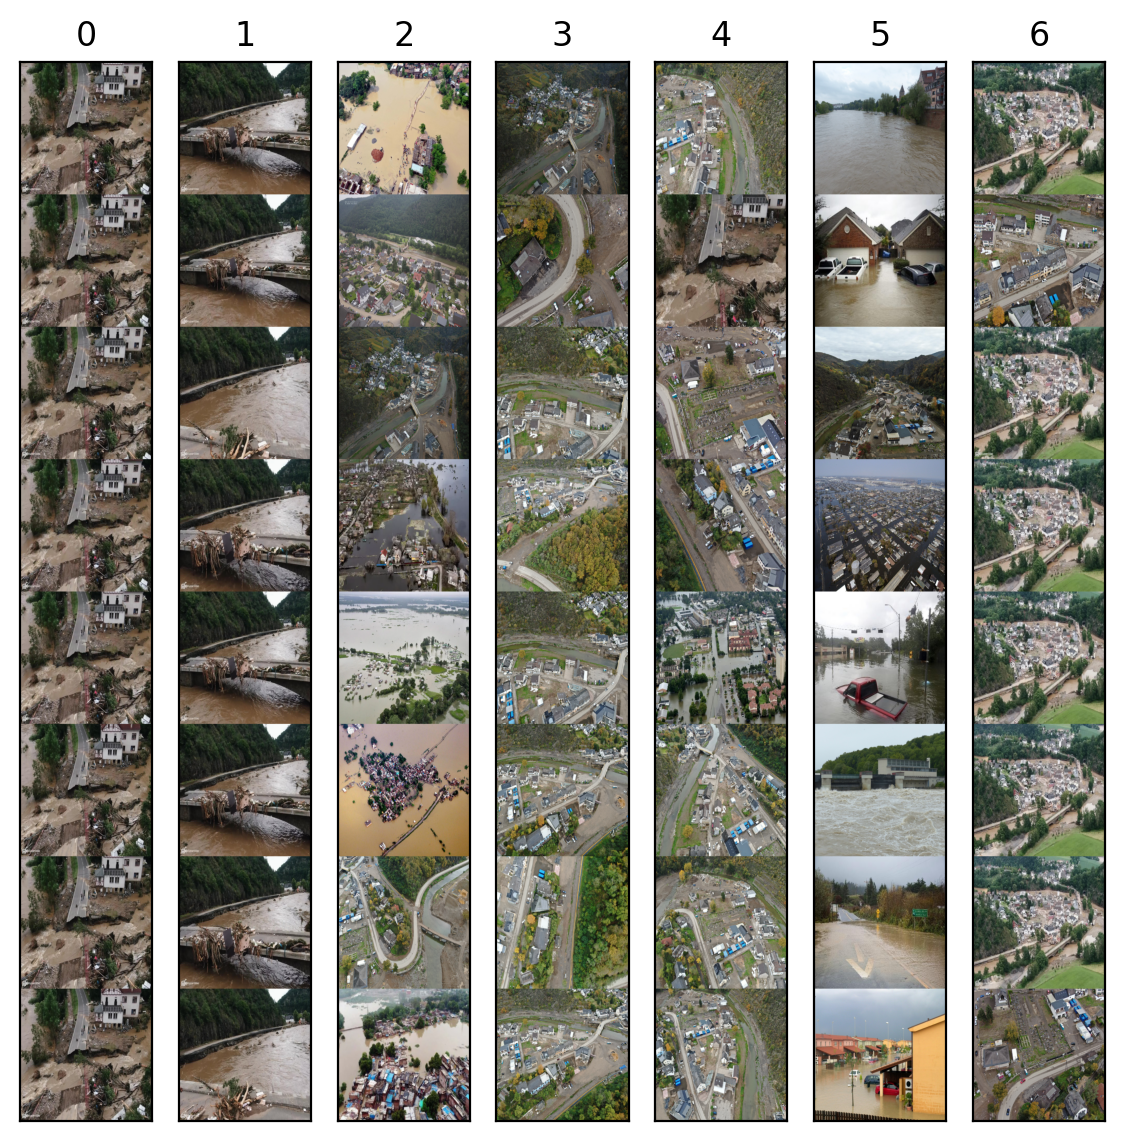

In [ ]:
proto_attr = prototypes[0]

distances = np.linalg.norm(attributions[:, None, :].detach().cpu() - proto_attr, axis=2)
prototype_samples = np.argsort(distances, axis=0)[:8]
prototype_samples = indices[prototype_samples]

fig, axs = plt.subplots(1, N_PROTOTYPES, figsize=(1*N_PROTOTYPES, 8), dpi=200, facecolor='white')


for i in range(N_PROTOTYPES):
    grid = make_grid(
        [dataset[prototype_samples[j][i]][0] for j in range(8)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f"{i}")


In [ ]:
# These are the preliminary ideas, re-run and see what would suit better, pay more attention to attribution UMAP since we use attributions further, not activations

num_prototypes = {
    "encoder.features.0": 2,
    "encoder.features.2": 2,
    "encoder.features.5": 2,
    "encoder.features.7": 2,
    "encoder.features.10": 2,
    "encoder.features.12": 7,
    "decoder.center.0.0": 7,
}

## PCX explanations

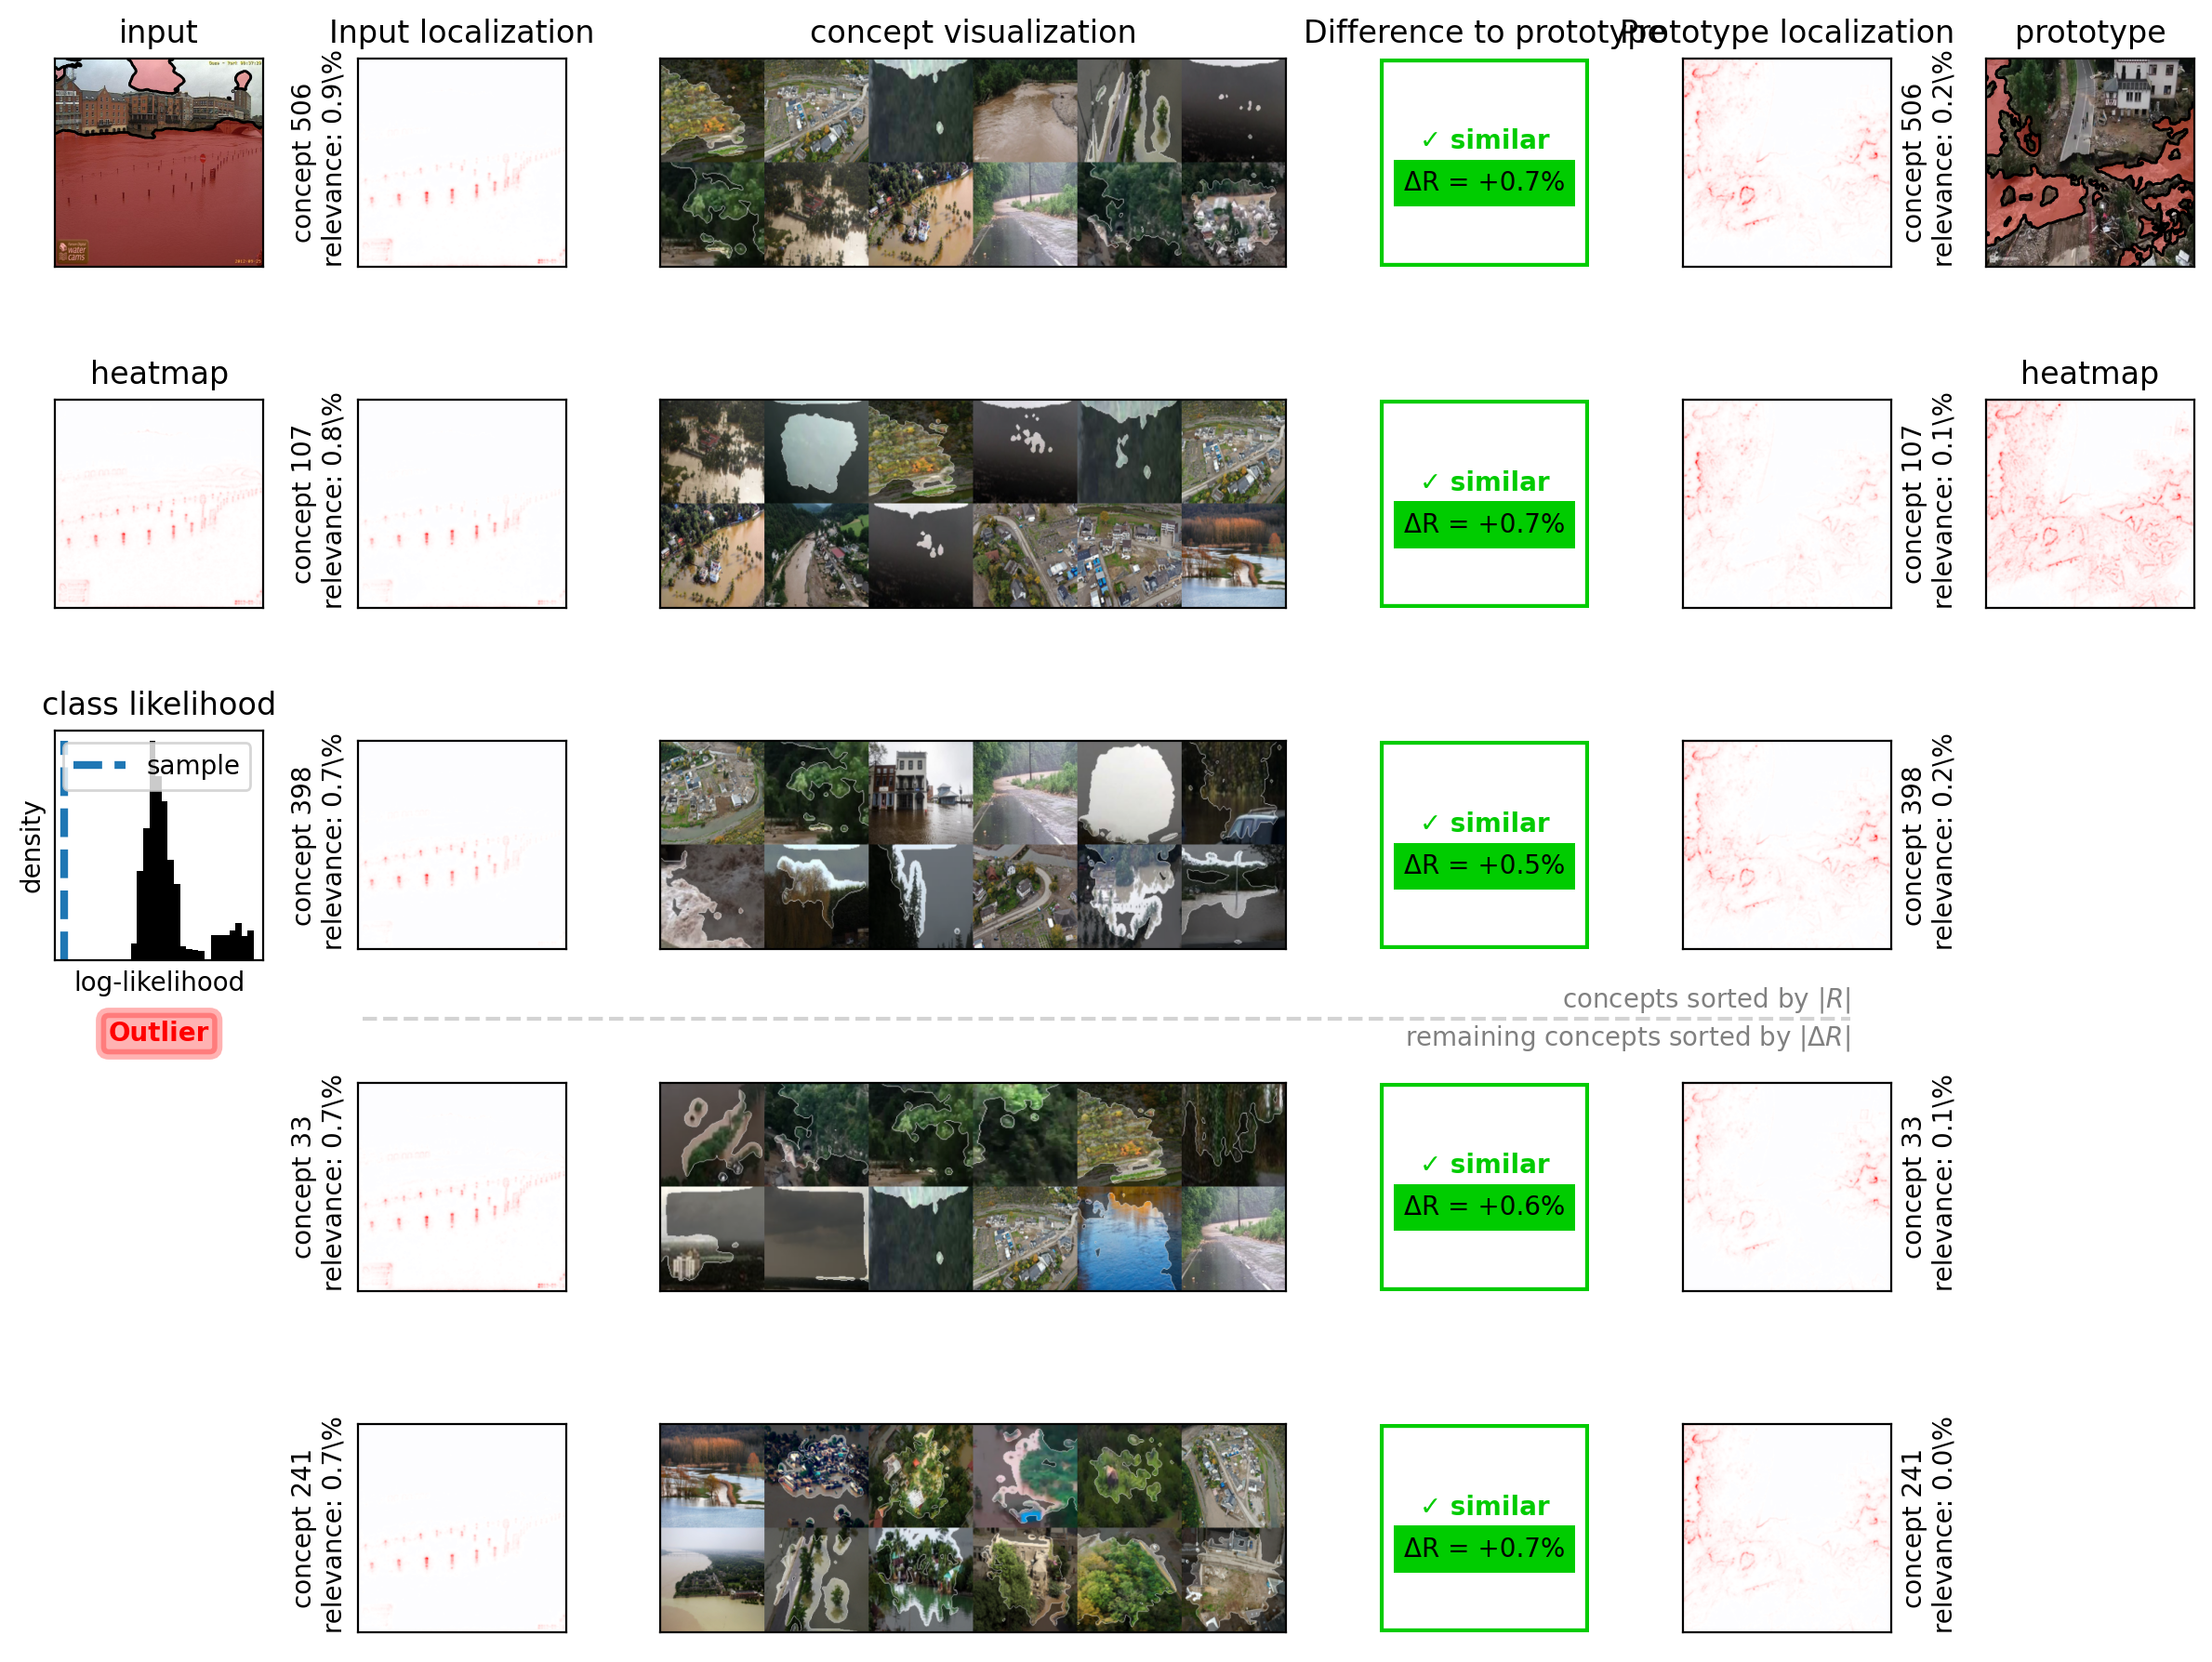

In [ ]:
# model.to("cpu")
layer_name = "decoder.center.0.0"
plot_pcx_explanations("unet", model, dataset, sample_id=0, num_prototypes=num_prototypes[layer_name], layer_name=layer_name)